For this recitation, we will be exploring class hierarchies using shapes. We are going to start by defining a parent class Shape that will represent any shape that one may want to draw. All shapes are going to have a color attribute that will be used when plotting, and will have a method to check if a point is inside a shape or not. All shapes will also have a method addToPlot that will draw a shape in a plot represented as a two dimensional array. 

In [1]:
class BoundingBox:
    def __init__(self, min_x, max_x, min_y, max_y):
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y

    def checkPoint(self, p):
        return self.min_x <= p[0] <= self.max_x and self.min_y <= p[1] <= self.max_y

    def combine(self, other):
        return BoundingBox(min(self.min_x, other.min_x),
                           max(self.max_x, other.max_x),
                           min(self.min_y, other.min_y),
                           max(self.max_y, other.max_y))

In [18]:
class Shape():
    def __init__(self, color, bbox):
        self.color = color
        self.bbox = bbox

    def checkPoint(self, p):
        '''
        This method will be different for different shapes.
        '''
        raise NotImplementedError

    def getColor(self):
        return self.color
    
    def getBoundingBox(self):
        return self.bbox

    def addToPlot(self, plot):
        '''
        This method iterates through the plot and checks if a point should be colored.
        '''
        plotDimensions = plot.shape
        for i in range(plotDimensions[0]):
            for j in range(plotDimensions[1]):
                p = (j,i)
                if self.checkPoint(p):
                    plot[i][j] = self.getColor()

 

Now, we are ready to define some basic shapes.

In [19]:
class Box(Shape):
    def __init__(self, color, lowerLeft, upperRight):
        
    def checkPoint(self, p):
        
    

class Circle(Shape):
    def __init__(self, color, center, radius):
        
        
    def checkPoint(self, p):
       

We can even define a Square as a special kind of box.

In [20]:
class Square(Box):
    
    

We can define a simple drawing function using matplotlib.

In [4]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt


def drawShapes(shapes):
    Z = np.array([[ 0   for j in range(0, 101)  ] for i in range(0, 101)])
    for s in shapes:
        s.addToPlot(Z)
    fig, ax = plt.subplots()
    im = ax.imshow(Z, cmap=cm.tab20c,
               origin='lower', extent=[0, 100, 0, 100],
               vmax=10, vmin=0)

    plt.show()

We can now draw a few different shapes.

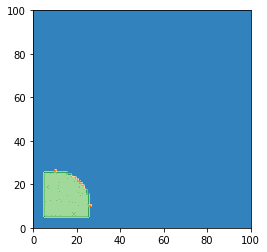

In [33]:
drawShapes([(Square(5, (5,5), 40)- Box(4, (10, 40), (80, 60)))* Circle(3, (10, 10), 16)])

We can also define shapes that represent Boolean combinations of other shapes.

In [22]:
class Combo(Shape):
    def __init__(self, shape1, shape2, chkPt):
        super().__init__(shape1.getColor(), shape1.getBoundingBox().combine(shape2.getBoundingBox()))
        self.chkPt = chkPt

    def checkPoint(self, p):
        return self.getBoundingBox().checkPoint(p) and self.chkPt(p)

class Union(Combo):
    def __init__(self, shape1, shape2):
        super().__init__(shape1, shape2, lambda p: shape1.checkPoint(p) or shape2.checkPoint(p))

class Dif(Combo):
    def __init__(self, shape1, shape2):
        super().__init__(shape1, shape2, lambda p: shape1.checkPoint(p) and not shape2.checkPoint(p))

class Intersect(Combo):
    def __init__(self, shape1, shape2):
        super().__init__(shape1, shape2, lambda p: shape1.checkPoint(p) and shape2.checkPoint(p))

You can even redefine the `+`, `-`, and `*` operators for the shape above to support a nice notation for combining shapes.

In [42]:
   def __add__(self, other):
        return Union(self, other)

    def __sub__(self, other):
        return Dif(self, other)
    
    def __mul__(self, other):
        return Intersect(self, other)

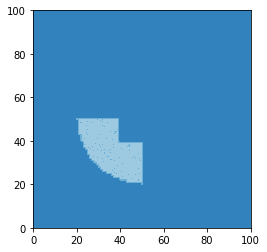

In [38]:
blob = (Square(1, (10, 10), 40) - Box(2, (40, 40), (80, 60))) * Circle(3, (50, 50), 30)
drawShapes([blob])

In [40]:
class ReColor(Shape):
    def __init__(self, shape, color):
        super().__init__(color, shape.getBoundingBox())
        self.shape = shape
        

    def checkPoint(self, p):
        return self.shape.checkPoint(p)
    

    
class Distort(Shape):
    def __init__(self, shape, translate):
        super().__init__(shape.getColor(), BoundingBox(0, 0, 0, 0))
        self.shape = shape
        self.translate = translate

    def checkPoint(self, p):
        return self.shape.checkPoint(self.translate(p))

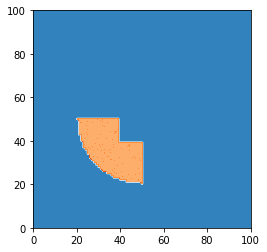

In [44]:
drawShapes([ReColor(blob, 3)])

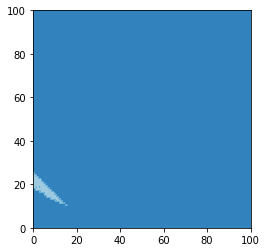

In [47]:
drawShapes([Distort(blob, lambda p: ((p[0]+p[1])*2, p[1]/2+15))])